In [72]:
import re
import string

import tensorflow as tf

from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding, TextVectorization, Bidirectional, Dropout
)
from tensorflow.keras.models import Model

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud

import swifter

In [55]:
DATA_DIRECTORY = "/kaggle/input/imdb-dataset-of-50k-movie-reviews"
MAX_VOCAB_SIZE = 30_000
SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 256
BATCH_SIZE = 64

In [32]:
df = pd.read_csv(f"{DATA_DIRECTORY}/IMDB Dataset.csv")

In [33]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [34]:
df["sentiment"] = df["sentiment"].swifter.allow_dask_on_strings(enable=True).apply(lambda x: 0. if x == "positive" else 1.)

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [35]:
translator = str.maketrans('', '', string.punctuation + string.digits)

In [36]:
def clean_text(text):
    text = re.sub(r"<.*?>", " ", text.lower())
    text = re.sub(r"https?://\S+", " ", text)
    text = text.translate(translator)
    text = " ".join(text.split())
    
    return text

In [37]:
df["review"] = df["review"].swifter.allow_dask_on_strings(enable=True).apply(clean_text)

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

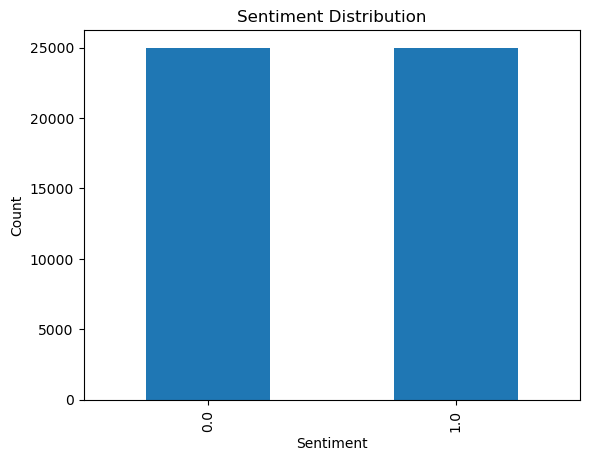

In [38]:
df["sentiment"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
_ = plt.ylabel("Count")

In [39]:
all_reviews = " ".join(review for review in df["review"])

In [40]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_reviews)

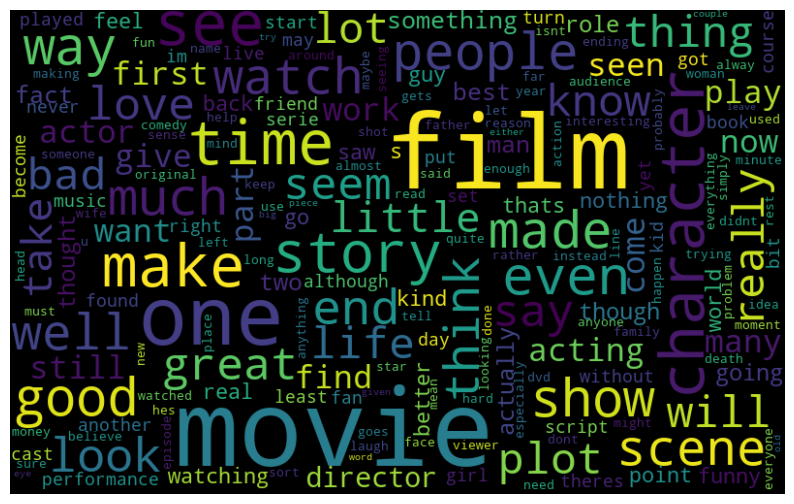

In [41]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
_ = plt.axis('off')

Text(0, 0.5, 'Count')

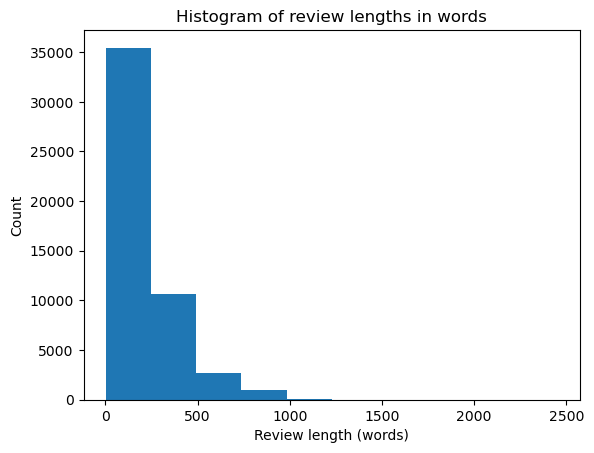

In [42]:
review_lengths = df["review"].apply(lambda x: len(x.split()))

plt.hist(review_lengths, bins=10)
plt.title("Histogram of review lengths in words")
plt.xlabel("Review length (words)")
plt.ylabel("Count")

In [43]:
def count_unique_words(data):
    all_strings = " ".join(str(string) for string in data)
    words = all_strings.split()
    unique_words = set(words)
    num_unique_words = len(unique_words)
    
    return num_unique_words

In [44]:
print(f"Number of unique words: {count_unique_words(df['review'])}")

Number of unique words: 163246


In [45]:
train, val = train_test_split(df, test_size=0.3, random_state=42, stratify=df.sentiment)

In [46]:
test = val.sample(frac=0.5, random_state=42)
val = val.drop(test.index)

In [47]:
train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [48]:
text_vectorization = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=SEQUENCE_LENGTH
)

In [49]:
text_vectorization.adapt(train["review"])

In [50]:
def build_lstm_model():
    text_input = Input(shape=(1,), dtype=tf.string)
    x = text_vectorization(text_input)
    x = Embedding(text_vectorization.vocabulary_size(), EMBEDDING_DIM)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    
    return Model(text_input, x)

In [56]:
lstm_model = build_lstm_model()

In [57]:
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 256)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 256, 256)          7680000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 256, 256)         394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                           

In [58]:
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.BinaryAccuracy()
)

In [59]:
lstm_model.fit(
    x=train["review"],
    y=train["sentiment"],
    validation_data=(val["review"], val["sentiment"]),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=3, 
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
1094/1094 [==============================] - 144s 125ms/step - loss: 0.4257 - binary_accuracy: 0.7787 - val_loss: 0.3150 - val_binary_accuracy: 0.8757
Epoch 2/50
1094/1094 [==============================] - 97s 89ms/step - loss: 0.2197 - binary_accuracy: 0.9154 - val_loss: 0.2946 - val_binary_accuracy: 0.8783
Epoch 3/50
1094/1094 [==============================] - 97s 89ms/step - loss: 0.1407 - binary_accuracy: 0.9508 - val_loss: 0.3326 - val_binary_accuracy: 0.8777
Epoch 4/50
1094/1094 [==============================] - 93s 85ms/step - loss: 0.0937 - binary_accuracy: 0.9701 - val_loss: 0.3555 - val_binary_accuracy: 0.8712
Epoch 5/50
1094/1094 [==============================] - 90s 82ms/step - loss: 0.0645 - binary_accuracy: 0.9807 - val_loss: 0.4225 - val_binary_accuracy: 0.8675


In [69]:
predictions = lstm_model.predict(test["review"])
predictions = tf.math.sigmoid(predictions).numpy()
predictions = [0. if x < 0.5 else 1. for x in predictions]

235/235 [==============================] - 6s 24ms/step


In [71]:
y_test = test["sentiment"].values.tolist()

In [76]:
print(f"Accuracy on test set: {accuracy_score(y_test, predictions) * 100}%")

Accuracy on test set: 87.64%
